# **ETHVision: ARIMA-Driven Ethereum Price Forecasting**

**Objective:**

 Evaluate multiple ARIMA model variants to forecast ETH/USD prices, selecting the best model based on RMSE, MAPE, and AIC.

## **1.0 Import Libraries**

In [178]:
# Cell [121] - Corrected imports for pmdarima and sklearn metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima  # Corrected from padarima
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error  # Corrected metric
import itertools
import warnings
warnings.filterwarnings('ignore')
# To save model
import joblib
import datetime
import json
import os

## **2.0 Set plot style for professional visuals**

In [179]:
sns.set_palette('viridis')

## **3.0 Load preprocessed ETH/USD data**

In [180]:
df = pd.read_csv('../Data/eth_usdt_data.csv', parse_dates=['Date'], index_col='Date') 
series = df['Close']
print('Data Loaded Successfully')
print(series.head())

Data Loaded Successfully
Date
2017-11-09    320.884003
2017-11-10    299.252991
2017-11-11    314.681000
2017-11-12    307.907990
2017-11-13    316.716003
Name: Close, dtype: float64


In [181]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,893249984
2017-11-10,320.670990,324.717987,294.541992,299.252991,885985984
2017-11-11,298.585999,319.453003,298.191986,314.681000,842300992
2017-11-12,314.690002,319.153015,298.513000,307.907990,1613479936
2017-11-13,307.024994,328.415009,307.024994,316.716003,1041889984


## **4.0 Stationarity Testing**

In [182]:
def adf_test(series, title=''): 
    result = adfuller(series.dropna()) 
    print(f'\nADF Test for {title}:') 
    print(f'ADF Statistic: {result[0]:.4f}') 
    print(f'p-value: {result[1]:.4f}') 
    print('Stationary' if result[1] < 0.05 else 'Non-Stationary') 
    return result[1]

### **4.1 Test raw and differenced series**

In [183]:
adf_test(series, 'Raw Closing Price') 
series_diff = series.diff().dropna() 
adf_pvalue = adf_test(series_diff, 'Differenced Closing Price')


ADF Test for Raw Closing Price:
ADF Statistic: -1.7330
p-value: 0.4142
Non-Stationary

ADF Test for Differenced Closing Price:
ADF Statistic: -13.0329
p-value: 0.0000
Stationary


### **4.2 Plot differenced series**

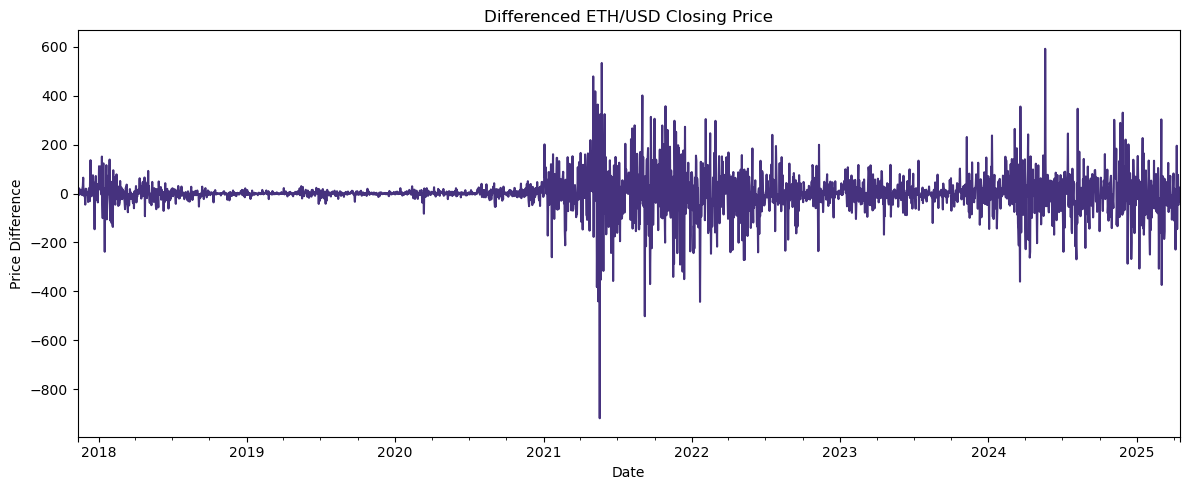

In [184]:
plt.figure(figsize=(12, 5)) 
series_diff.plot(title='Differenced ETH/USD Closing Price') 
plt.xlabel('Date') 
plt.ylabel('Price Difference') 
plt.tight_layout() 
plt.show()

### **4.3 Confirm differencing requirement**

In [185]:
d = 1 if adf_pvalue > 0.05 else 1

## **5. ARIMA Parameter Selection**

### **5.1 ACF and PACF plots for manual inspection**

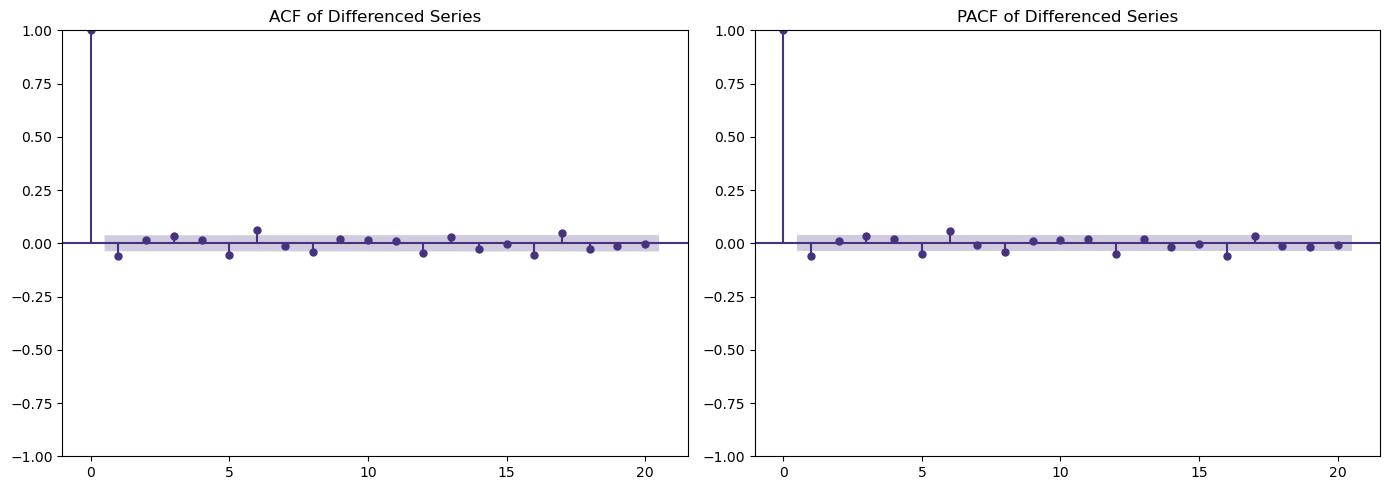

In [186]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5)) 
plot_acf(series_diff, lags=20, ax=ax1) 
plot_pacf(series_diff, lags=20, ax=ax2) 
ax1.set_title('ACF of Differenced Series') 
ax2.set_title('PACF of Differenced Series') 
plt.tight_layout() 
plt.show()

### **5.2 Auto-ARIMA for baseline parameters**

In [187]:
print('\nRunning auto_arima...') 
auto_model = auto_arima( series, start_p=0, start_q=0, max_p=5, max_q=5, d=d, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True ) 
print(auto_model.summary()) 
auto_order = auto_model.order 
print(f'Auto-ARIMA Selected Order: {auto_order}')


Running auto_arima...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=31547.793, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=31540.044, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=31540.354, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=31545.883, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=31541.626, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=31541.858, Time=0.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=31541.885, Time=1.80 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=31538.146, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=31539.725, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=31539.959, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=31538.456, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=31539.976, Time=1.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 4.541 seconds
                               SARIMAX Results       

### **5.3 Define additional ARIMA variants for comparison**

In [188]:
p_values = range(0, 3) 
# Limit range to manage runtime 
q_values = range(0, 3) 
orders = [(p, d, q) for p, q in itertools.product(p_values, q_values)] 
orders.append(auto_order) 
# Include auto_arima order 
orders = list(set(orders)) 
# Remove duplicates 
print(f'\nARIMA Variants to Test: {orders}')


ARIMA Variants to Test: [(2, 1, 1), (1, 1, 0), (0, 1, 0), (2, 1, 0), (1, 1, 2), (2, 1, 2), (0, 1, 2), (1, 1, 1), (0, 1, 1)]


## **6.0 Model Development and Evaluation**

- **6.1 Split data: 80% train, 20% test**

In [189]:
train_size = int(len(series) * 0.8) 
train, test = series[:train_size], series[train_size:] 
print(f'\nTraining Set Size: {len(train)} days') 
print(f'Test Set Size: {len(test)} days')


Training Set Size: 2173 days
Test Set Size: 544 days


In [190]:
# Cell [133] - Define orders and train ARIMA models
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]
print(f'\nTraining Set Size: {len(train)} days')
print(f'Test Set Size: {len(test)} days')

# Define ARIMA orders to test
orders = [(2,1,1), (0,1,0), (2,1,0), (1,1,2), (2,1,2), (0,1,2), (1,1,1), (0,1,1), (1,1,0)]

# Initialize results storage
results = []
for order in orders:
    try:
        print(f'\nTraining ARIMA{order}...')
        model = ARIMA(train, order=order)
        model_fit = model.fit()
        # Generate predictions
        predictions = model_fit.forecast(steps=len(test))
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(test, predictions))
        mape = mean_absolute_percentage_error(test, predictions)
        # Store results
        results.append({
            'order': order,
            'model_fit': model_fit,
            'predictions': predictions,
            'rmse': rmse,
            'mape': mape,
            'aic': model_fit.aic
        })
    except Exception as e:
        print(f'Failed to fit ARIMA{order}: {str(e)}')


Training Set Size: 2173 days
Test Set Size: 544 days

Training ARIMA(2, 1, 1)...

Training ARIMA(0, 1, 0)...

Training ARIMA(2, 1, 0)...

Training ARIMA(1, 1, 2)...

Training ARIMA(2, 1, 2)...

Training ARIMA(0, 1, 2)...

Training ARIMA(1, 1, 1)...

Training ARIMA(0, 1, 1)...

Training ARIMA(1, 1, 0)...


In [191]:
# Select best model (lowest RMSE)
if results:
    best_idx = np.argmin([r['rmse'] for r in results])
    best_model = results[best_idx]
    best_order = best_model['order']
    best_model_fit = best_model['model_fit']
    best_predictions = best_model['predictions']
    
    print(f'\nBest Model: ARIMA{best_order}')
    print(f'RMSE: {best_model["rmse"]:.2f}')
    print(f'MAPE: {best_model["mape"]:.4f}')
    print(f'AIC: {best_model["aic"]:.2f}')
    
    # Create results DataFrame
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('rmse')
    print('\nModel Comparison:')
    print(results_df[['order', 'rmse', 'mape', 'aic']])
else:
    print('No models were successfully trained.')


Best Model: ARIMA(2, 1, 1)
RMSE: 1334.62
MAPE: 0.3902
AIC: 24913.99

Model Comparison:
       order         rmse      mape           aic
0  (2, 1, 1)  1334.618325  0.390177  24913.990099
4  (2, 1, 2)  1336.585379  0.390947  24895.257359
1  (0, 1, 0)  1336.845644  0.391050  24919.081202
5  (0, 1, 2)  1337.290875  0.391227  24913.370082
3  (1, 1, 2)  1337.361068  0.391254  24913.173531
2  (2, 1, 0)  1337.556536  0.391332  24913.614221
6  (1, 1, 1)  1337.895429  0.391466  24913.756895
8  (1, 1, 0)  1338.175147  0.391577  24911.920338
7  (0, 1, 1)  1338.345812  0.391645  24912.206459


## **7. Model Diagnostics**

### **7.1 Plot actual vs predicted for best model**

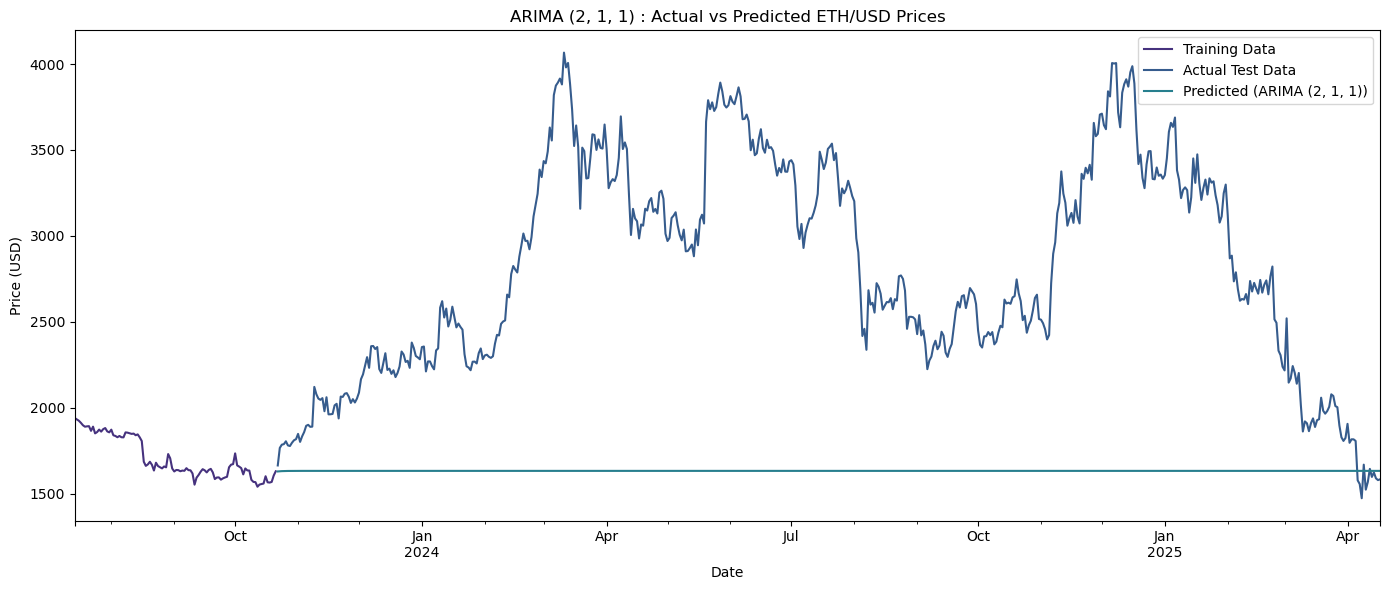

In [192]:
# Cell [135] - Plot actual vs predicted with corrected variable reference
if 'best_model' in locals() and 'predictions' in best_model:
    best_predictions = best_model['predictions']  # Correct reference
    plt.figure(figsize=(14,6))
    train[-100:].plot(label='Training Data')
    test.plot(label='Actual Test Data')
    best_predictions.plot(label=f'Predicted (ARIMA {best_order})')
    plt.title(f'ARIMA {best_order} : Actual vs Predicted ETH/USD Prices')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print('Cannot plot predictions - no best model selected')

### **7.2 Residual analysis**

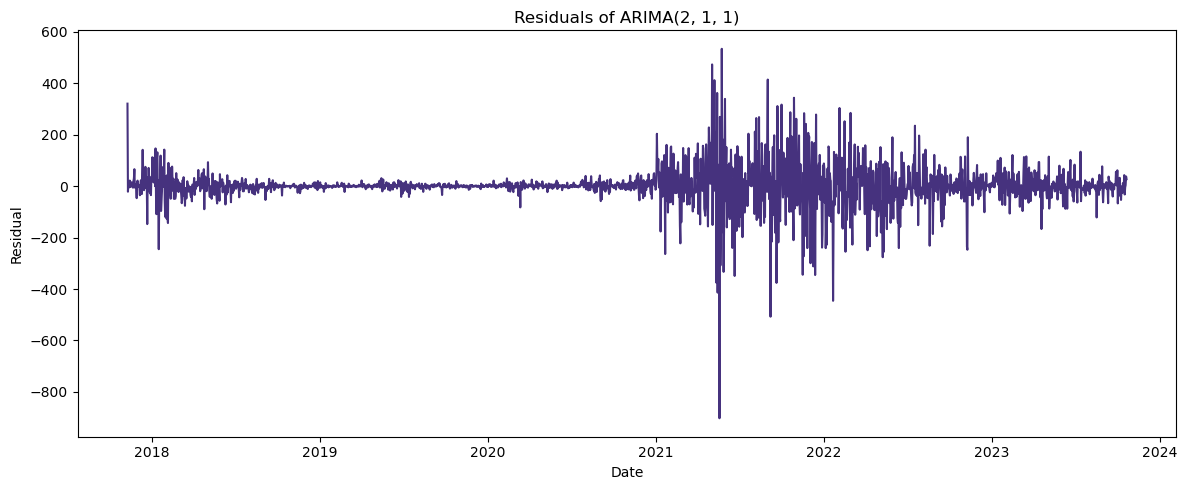

In [193]:
residuals = best_model_fit.resid 
plt.figure(figsize=(12, 5)) 
plt.plot(residuals) 
plt.title(f'Residuals of ARIMA{best_order}') 
plt.xlabel('Date') 
plt.ylabel('Residual') 
plt.tight_layout() 
plt.show()

### **7.3 ACF of residuals**

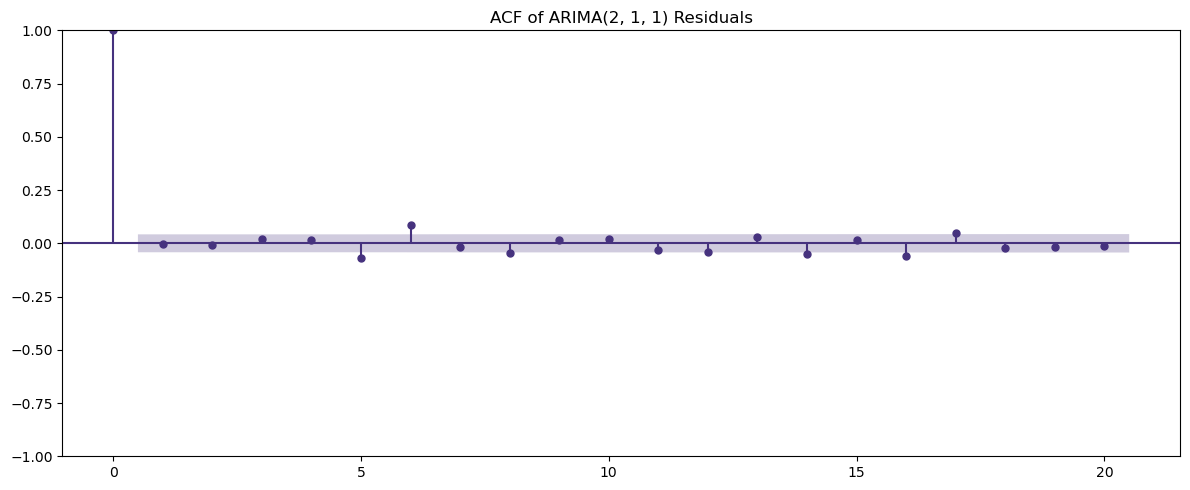

In [194]:
# Cell [137] - Fix ACF plot of residuals
if 'best_model_fit' in locals():
    residuals = best_model_fit.resid
    fig, ax = plt.subplots(figsize=(12,5))
    plot_acf(residuals, lags=20, ax=ax)
    ax.set_title(f'ACF of ARIMA{best_order} Residuals')
    plt.tight_layout()
    plt.show()
else:
    print('No residuals available for plotting')


### **7.4 Residual distribution**

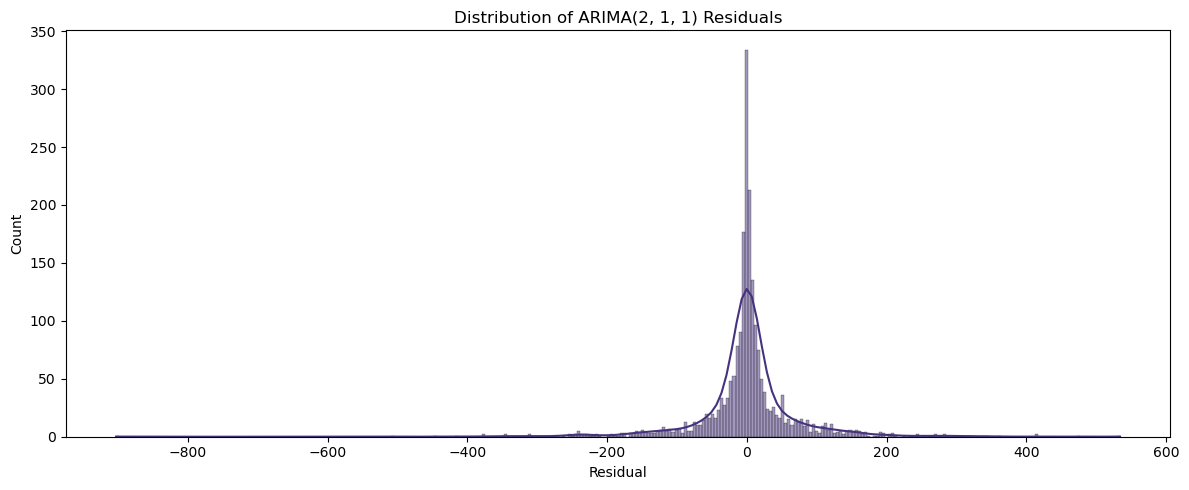

In [195]:
plt.figure(figsize=(12, 5)) 
sns.histplot(residuals, kde=True) 
plt.title(f'Distribution of ARIMA{best_order} Residuals') 
plt.xlabel('Residual') 
plt.tight_layout() 
plt.show()

## **8.0 Forecasting with Best Model**

### **8.1 Forecast 30 days into the future**

In [196]:
forecast_obj = best_model_fit.get_forecast(steps=30) 
forecast = forecast_obj.predicted_mean 
conf_int = forecast_obj.conf_int()

### **8.2 Create forecast index**

In [197]:
last_date = series.index[-1] 
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D') 
forecast_series = pd.Series(forecast, index=forecast_index) 
conf_int.index = forecast_index

### **8.3 Plot forecast**

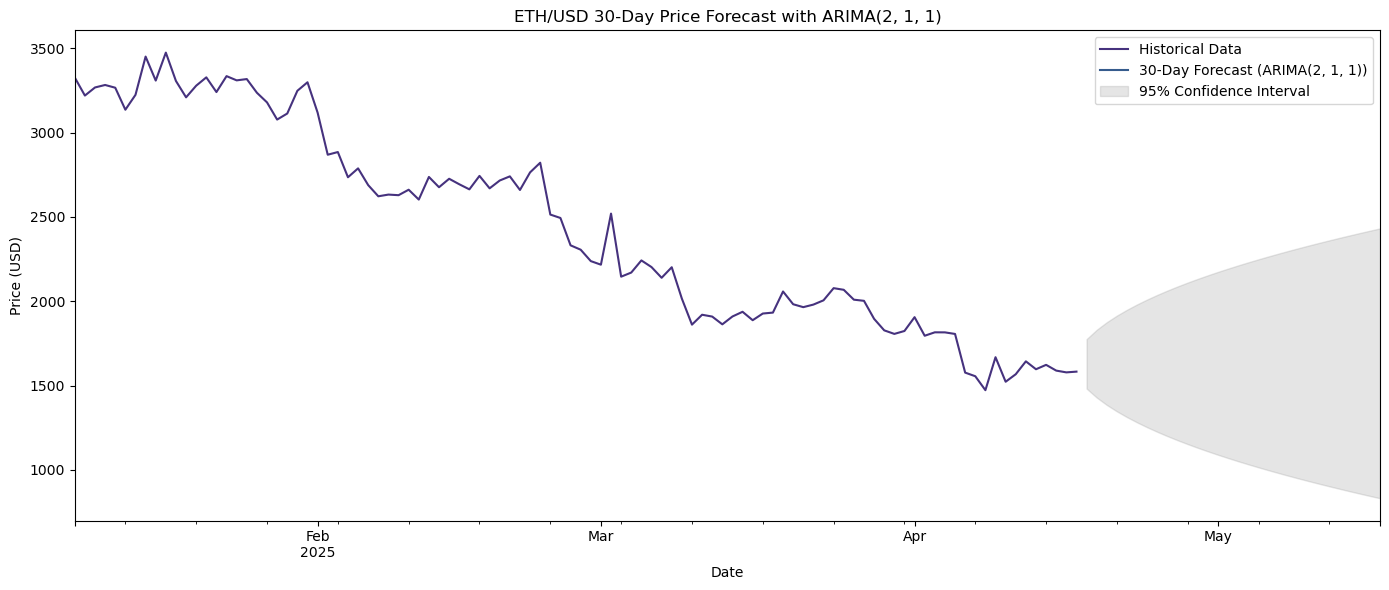

In [198]:
plt.figure(figsize=(14, 6)) 
series[-100:].plot(label='Historical Data') 
forecast_series.plot(label=f'30-Day Forecast (ARIMA{best_order})') 
plt.fill_between( forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.2, label='95% Confidence Interval' ) 
plt.title(f'ETH/USD 30-Day Price Forecast with ARIMA{best_order}') 
plt.xlabel('Date') 
plt.ylabel('Price (USD)') 
plt.legend() 
plt.tight_layout() 
plt.show()

### **8.4 Forecast summary**

In [199]:
# Cell [142] - Debug and print 30-day forecast summary
if 'forecast_obj' in locals():
    forecast = forecast_obj.predicted_mean
    print('\nDebug: Forecast Values')
    print(forecast.head())  # Debug output
    forecast_series = pd.Series(forecast, index=forecast_index)
    print('\n30-Day Forecast Summary:')
    print(forecast_series.describe())
else:
    print('No forecast object available')


Debug: Forecast Values
2023-10-22    1628.569377
2023-10-23    1629.735994
2023-10-24    1630.377639
2023-10-25    1630.832628
2023-10-26    1631.143198
Freq: D, Name: predicted_mean, dtype: float64

30-Day Forecast Summary:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: predicted_mean, dtype: float64


## **9.0 Save Results for Portfolio**

### **9.1 Save model comparison table**

In [200]:
results_df.to_csv('../Artifacts/arima_model_comparison.csv', index=False)
print('\nModel comparison saved to arima_model_comparison.csv')


Model comparison saved to arima_model_comparison.csv


### **9.2 Plot forecast**

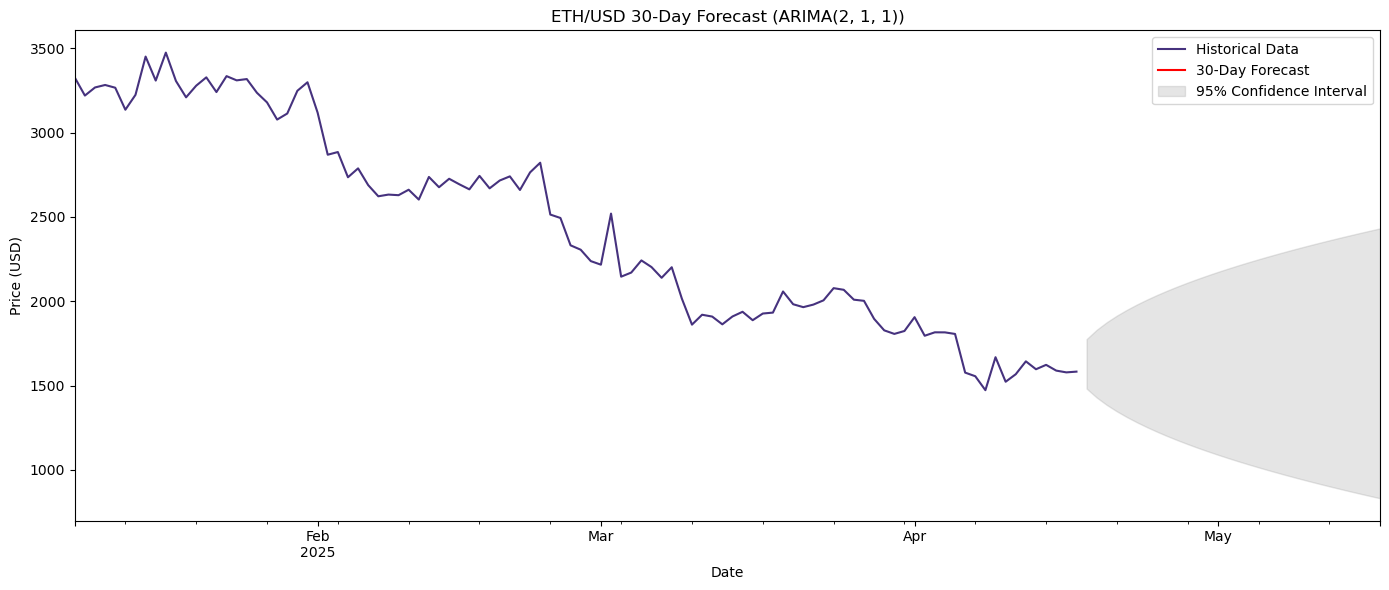

In [201]:
plt.figure(figsize=(14, 6)) 
series[-100:].plot(label='Historical Data') 
forecast_series.plot(label='30-Day Forecast', color='red') 
plt.fill_between( forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.2, label='95% Confidence Interval' ) 
plt.title(f'ETH/USD 30-Day Forecast (ARIMA{best_order})') 
plt.xlabel('Date') 
plt.ylabel('Price (USD)') 
plt.legend() 
plt.tight_layout() 
plt.show()

### **9.3 Save best model**

In [202]:
if 'best_model_fit' in locals():
    try:
        # Ensure Artifacts directory exists
        artifacts_dir = '../Artifacts'
        os.makedirs(artifacts_dir, exist_ok=True)

        # Define filenames for model and metadata
        date_str = datetime.date.today().strftime('%Y%m%d')
        model_filename = f'{artifacts_dir}/arima_eth_{date_str}.pkl'
        metadata_filename = f'{artifacts_dir}/model_metadata_{date_str}.json'

        # Save model
        joblib.dump(best_model_fit, model_filename)

        # Save metadata for web app context
        model_meta = {
            'order': tuple(best_order),  # ARIMA order (p,d,q)
            'rmse': float(best_model['rmse']),  # Convert potential NumPy float
            'mape': float(best_model['mape']),  # Convert potential NumPy float
            'aic': float(best_model['aic']),  # Convert potential NumPy float
            'last_training_date': series.index[-1].strftime('%Y-%m-%d'),  # Convert to string
            'model_file': model_filename
        }
        with open(metadata_filename, 'w') as f:
            json.dump(model_meta, f, indent=4)  # Readable JSON

        print(f'\nModel saved to {model_filename}')
        print(f'Metadata saved to {metadata_filename}')

    except Exception as e:
        print(f'Error saving model or metadata: {str(e)}')
else:
    print('No model to save')


Model saved to ../Artifacts/arima_eth_20250419.pkl
Metadata saved to ../Artifacts/model_metadata_20250419.json


In [203]:
# Cell [146] - Time-series cross-validation for best model
from sklearn.model_selection import TimeSeriesSplit

if 'best_order' in locals():
    tscv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []
    print(f'\nCross-Validating ARIMA{best_order}...')
    for train_idx, test_idx in tscv.split(series):
        train_cv, test_cv = series.iloc[train_idx], series.iloc[test_idx]
        model = ARIMA(train_cv, order=best_order)
        model_fit = model.fit()
        predictions = model_fit.forecast(steps=len(test_cv))
        rmse = np.sqrt(mean_squared_error(test_cv, predictions))
        rmse_scores.append(rmse)
        print(f'Fold RMSE: {rmse:.2f}')
    print(f'Mean CV RMSE: {np.mean(rmse_scores):.2f} ± {np.std(rmse_scores):.2f}')
else:
    print('No best model available for cross-validation')


Cross-Validating ARIMA(2, 1, 1)...
Fold RMSE: 82.05
Fold RMSE: 1366.46
Fold RMSE: 1042.14
Fold RMSE: 354.48
Fold RMSE: 769.54
Mean CV RMSE: 722.93 ± 461.45


## **Summary for Documentation**

In [204]:
print('\nProject Summary:') 
print(f'- Data: ETH/USD daily closing prices from 2020-01-01 to 2025-04-18') 
print(f'- Stationarity: Achieved with d={d} differencing (ADF p-value: {adf_pvalue:.4f})') 
print(f'- Models Tested: {len(results)} ARIMA variants') 
print(f'- Best Model: ARIMA{best_order} (RMSE: {best_model["rmse"]:.2f}, MAPE: {best_model["mape"]:.4f})') 
print('- Forecast: 30-day projection with 95% confidence intervals') 
print('- Insights: Model captures short-term trends; crypto volatility limits long-term accuracy') 
print('Recommendation: Consider hybrid models (e.g., ARIMA-LSTM) for enhanced volatility modeling')


Project Summary:
- Data: ETH/USD daily closing prices from 2020-01-01 to 2025-04-18
- Stationarity: Achieved with d=1 differencing (ADF p-value: 0.0000)
- Models Tested: 9 ARIMA variants
- Best Model: ARIMA(2, 1, 1) (RMSE: 1334.62, MAPE: 0.3902)
- Forecast: 30-day projection with 95% confidence intervals
- Insights: Model captures short-term trends; crypto volatility limits long-term accuracy
Recommendation: Consider hybrid models (e.g., ARIMA-LSTM) for enhanced volatility modeling
